<a href="https://colab.research.google.com/github/danny4159/Classification-of-spinal-cord-tumors/blob/master/Googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import division, print_function, absolute_import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf

import keras

import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
from google.colab import files
uploaded_train = files.upload()

Saving train.csv to train.csv


In [ ]:
from google.colab import files
uploaded_test = files.upload()

Saving test.csv to test.csv


In [ ]:
import io
train = pd.read_csv(io.BytesIO(uploaded_train['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded_test['test.csv']))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


3    105
1    105
0    103
2     83
Name: label, dtype: int64

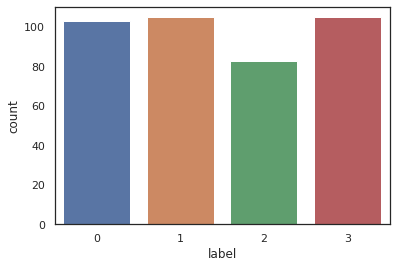

In [ ]:
Y_train = train["label"]

# 'label' column 을 drop
X_train = train.drop(labels = ["label"],axis = 1) 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [ ]:
X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [ ]:
Y_train = to_categorical(Y_train, num_classes = 4)

In [ ]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size = 0.1, 
                                                  random_state=random_seed)

In [ ]:
모델 설정

SyntaxError: ignored

In [ ]:
def googlenet(inputShape, nOfClasses):
    
         
    def inceptionBlock(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)
          
        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3,padding='same', activation='relu')(t2)
                    
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5,padding='same', activation='relu')(t3)
          
        t4= MaxPool2D(3, 1, padding='same')(x)
        t4= Conv2D(f[5], 1, activation='relu')(t4)
          
        output = Concatenate()([t1,t2,t3,t4])
        return output
      
    input = Input(inputShape)
        
    x = Conv2D(64, 7 ,strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x= Conv2D(64, 1, activation='relu')(x)
    x= Conv2D(192, 3, padding='same', activation='relu')(x)
    x= MaxPool2D(3 , strides=2)(x)     
    
    
    x = inceptionBlock(x, [64, 96, 128, 16, 32, 32])
    x = inceptionBlock(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
      
    x = inceptionBlock(x, [192, 96, 208, 16, 48, 64])
    x = inceptionBlock(x, [160, 112, 224, 24, 64, 64])
    x = inceptionBlock(x, [128, 128, 256, 24, 64, 64])
    x = inceptionBlock(x, [112, 144, 288, 32, 64, 64])
    x = inceptionBlock(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inceptionBlock(x, [256, 160, 320, 32, 128, 128])
    x = inceptionBlock(x, [384, 192, 384, 48, 128, 128])
      
     
    x =GlobalAvgPool2D()(x)
    x = Dropout(0.4)(x)
     
     
    output = Dense(nOfClasses ,activation='softmax')(x)
    model = Model(input, output)
    return model

In [ ]:
inputShape = 28,28,1
nOfClasses = 4
K.clear_session()
model = googlenet(inputShape, nOfClasses)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 7, 7, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     4160        max_pooling2d[0][0]              
_______________________________________________________________________________________

In [ ]:
# 이건 내 keras 보고서에서 가져온거
model.compile(optimizer = Adam(lr=0.001), loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(X_train, Y_train, epochs=30, validation_data = (X_val,Y_val)) # batch_size=100, verbose=1

Epoch 1/30
12/12 [==============================] - 1s 63ms/step - loss: 1.3836 - accuracy: 0.2528 - val_loss: 1.3486 - val_accuracy: 0.2750
Epoch 2/30
12/12 [==============================] - 0s 19ms/step - loss: 1.3808 - accuracy: 0.2500 - val_loss: 1.3671 - val_accuracy: 0.2750
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 1.2702 - accuracy: 0.3567 - val_loss: 1.2573 - val_accuracy: 0.5000
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 1.1284 - accuracy: 0.4551 - val_loss: 1.0064 - val_accuracy: 0.5750
Epoch 5/30
12/12 [==============================] - 0s 16ms/step - loss: 0.9278 - accuracy: 0.5506 - val_loss: 1.7547 - val_accuracy: 0.2000
Epoch 6/30
12/12 [==============================] - 0s 16ms/step - loss: 0.9618 - accuracy: 0.4831 - val_loss: 0.8957 - val_accuracy: 0.6000
Epoch 7/30
12/12 [==============================] - 0s 16ms/step - loss: 0.8585 - accuracy: 0.5758 - val_loss: 0.7923 - val_accuracy: 0.6750
Epoch 8/30
12